In [1]:
import torch as t
from mcs import MCS
from PIL import Image
from scipy import ndimage
import numpy as np

In [26]:
init_state = t.zeros(1,8,8)
init_state[0,4,4] += 1

target_vol = 1.
temperature = t.tensor(27.)
temperature.requires_grad_()

tensor(27., requires_grad=True)

In [ ]:
states = [init_state.detach().clone().squeeze().numpy()]
state = init_state.detach().clone()
for i in range(1000):
    print(f"-------- MCS {i} --------------")
    state = MCS(state, target_vol, temperature)
    print(state)
    states.append(state.detach().clone().squeeze().numpy())
    if t.sum(state) == 0 or t.sum(state) > 2:
        print("ISSUE DETECTED, STOP SIM",t.sum(state))
        break

imgs = [Image.fromarray((1-state)*255) for state in states]
imgs[0].save("t_1_reflective.gif", save_all=True, append_images=imgs[1:], duration=10, loop=100)

In [28]:
col_idxs = t.arange(8.0).repeat(8, 1) + 1
row_idxs = t.arange(8.0).repeat(8, 1).T + 1

x_mean = t.sum(init_state * col_idxs) / t.sum(init_state)
y_mean = t.sum(init_state * row_idxs) / t.sum(init_state)
print(init_state)
print(x_mean, y_mean)

x_mean_adjusted = t.sum(state * col_idxs) / t.sum(state)
y_mean_adjusted = t.sum(state * row_idxs) / t.sum(state)
print(state)
print(x_mean_adjusted, y_mean_adjusted)

t.autograd.grad(t.sum((state - init_state)**2), temperature, retain_graph=True)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]])
tensor(5.) tensor(5.)


In [33]:
dist = t.sqrt((x_mean - x_mean_adjusted)**2 + (y_mean-y_mean_adjusted)**2)
print(dist)
t.autograd.grad(dist, temperature)

tensor(4., grad_fn=<PowBackward0>)
tensor(2.0616, grad_fn=<SqrtBackward0>)


In [12]:
def step(grid:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float):
    temperature.requires_grad_()
    for i in range(1000):
        print(f"-------- MCS {i} --------------")
        grid = MCS(grid, target_vol, temperature)
        print(grid)
        if t.sum(grid) == 0 or t.sum(grid) > 2:
            print("ISSUE DETECTED, STOP SIM",t.sum(grid))
            return None, None
    # calc the distance after 1000 steps    
    dist = t.sum(grid * dist_matrix) / t.sum(grid)
    grad = t.autograd.grad(dist, temperature)[0]
    return temperature - eta * grad, grad

In [13]:
init_state = t.zeros(1,8,8)
init_state[0,4,4] += 1

target_vol = 1.
temperature = t.tensor(27.)

dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-init_state, return_indices=False)
dist_matrix = dist_matrix**2
dist_matrix_t = t.from_numpy(dist_matrix)

print(dist_matrix_t)

tensor([[[32.0000, 25.0000, 20.0000, 17.0000, 16.0000, 17.0000, 20.0000,
          25.0000],
         [25.0000, 18.0000, 13.0000, 10.0000,  9.0000, 10.0000, 13.0000,
          18.0000],
         [20.0000, 13.0000,  8.0000,  5.0000,  4.0000,  5.0000,  8.0000,
          13.0000],
         [17.0000, 10.0000,  5.0000,  2.0000,  1.0000,  2.0000,  5.0000,
          10.0000],
         [16.0000,  9.0000,  4.0000,  1.0000,  0.0000,  1.0000,  4.0000,
           9.0000],
         [17.0000, 10.0000,  5.0000,  2.0000,  1.0000,  2.0000,  5.0000,
          10.0000],
         [20.0000, 13.0000,  8.0000,  5.0000,  4.0000,  5.0000,  8.0000,
          13.0000],
         [25.0000, 18.0000, 13.0000, 10.0000,  9.0000, 10.0000, 13.0000,
          18.0000]]], dtype=torch.float64)


In [ ]:
grads = []
temps = []
for i in range(200):
    temperature, grad = step(init_state, dist_matrix_t, temperature, target_vol, eta=1)
    if temperature == None or grad == None:
        print("issue encountered in the simulations, stopping training")
        break
    else:
        grads.append(grad.detach().cpu().numpy())
        temps.append(temperature.detach().cpu().numpy())

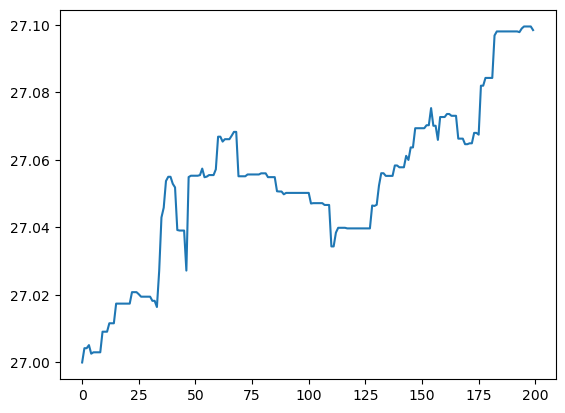

In [15]:
import matplotlib.pyplot as plt

plt.plot(np.arange(200), temps)

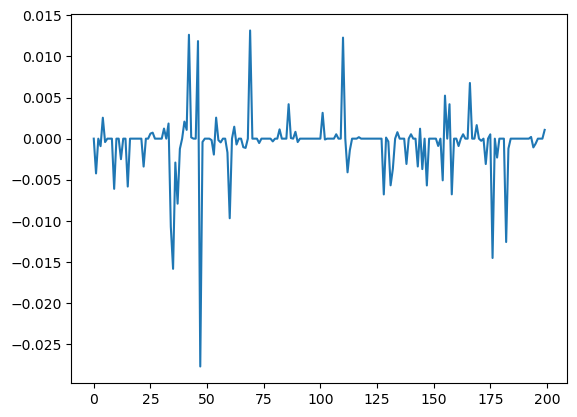

In [16]:
plt.plot(np.arange(200), grads)